In [4]:
# These are all the modules we'll be using later. Make sure you can import them
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import json
from six.moves.urllib.request import urlretrieve

In [28]:
url = 'http://orange.com/wgmn4901/data/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename) # may not work as expected
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

clustersnapshot = maybe_download('clustersnapshot24022016.tar.gz', 249468)

Found and verified clustersnapshot24022016.tar.gz


In [37]:
def maybe_extract(filename,force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  print('Found the following application profile in %s:' % filename)
  for folder in data_folders:
    print ('  %s' % folder)
  return data_folders
  
clustersnapshot_folders = maybe_extract(clustersnapshot)

clustersnapshot24022016 already present - Skipping extraction of clustersnapshot24022016.tar.gz.
Found the following application profile in clustersnapshot24022016.tar.gz:
  clustersnapshot24022016/application_1456319042576_0003_json
  clustersnapshot24022016/application_1456319042576_0004_json
  clustersnapshot24022016/application_1456319042576_0005_json
  clustersnapshot24022016/application_1456319042576_0006_json
  clustersnapshot24022016/application_1456319042576_0007_json


In [246]:
import pandas as pd #this is how I usually import pandas

def load_application(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_task_list = []
  container_node_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_task = data["container_tasks"][0]["task_type"] #First task only
        if not data["nodeInfo"]:
            container_node = "null"
        else:
            container_node = data["nodeInfo"]["id"]
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_task_list.insert(container_index,container_task)
        container_node_list.insert(container_index,container_node)
      if not container_name:
        raise Exception('Unexpected container name')
      if container_starttime == 0:
        raise Exception('Unexpected container start time')
      if container_endtime == 0:
        raise Exception('Unexpected container end time')
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(container_starttime_list,container_endtime_list,container_task_list,container_node_list))
  DataFrame = pd.DataFrame(data = DataSet, index=container_name_list, columns=[ 'start', 'end', 'task', 'node'])
  return DataFrame, application_starttime, application_endtime

def load_snapshot(snapshot_folders):
  snapshot_starttime = 100000000000000 # really big number
  snapshot_endtime = 0
  snapshot_dataframe = pd.DataFrame()
  for application_folder in snapshot_folders: 
    dataframe, application_starttime, application_endtime = load_application(application_folder)
    if application_starttime < snapshot_starttime:
      snapshot_starttime = application_starttime
    if application_endtime > snapshot_endtime:
      snapshot_endtime = application_endtime
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
  return snapshot_dataframe, snapshot_starttime, snapshot_endtime

snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))

Snapshot start time: 1456334801869
Snapshot end time: 1456335271858
Snapshot duration: 469989 ms (or ~469 s or ~7 m)


App application_1456319042576_0006_json is selected for this example


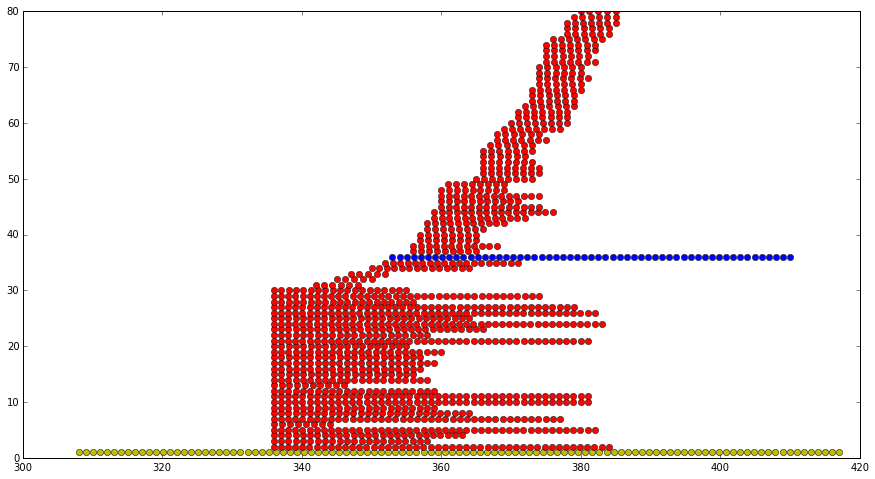

In [284]:
# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import matplotlib.pyplot as plt
import matplotlib #only needed to determine Matplotlib version number
from random import randint
import pylab

# Enable inline plotting
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

random_application = clustersnapshot_folders[randint(0,len(clustersnapshot_folders)-1)]
print("App %s is selected for this example" % random_application.split('/')[1])

DataFrame, application_starttime, application_endtime = load_application(random_application)
DataFrameSorted = DataFrame.sort(columns="start")

value = 1
for index in DataFrameSorted.index:
  starttime_rescaled = DataFrameSorted.loc[index,"start"]/1000 - snapshot_starttime/1000
  endtime_rescaled = DataFrameSorted.loc[index,"end"]/1000 - snapshot_starttime/1000
  task_duration = endtime_rescaled - starttime_rescaled
  x = np.linspace(starttime_rescaled,endtime_rescaled,task_duration)
  container_data = np.linspace(value,value,task_duration)
  if DataFrameSorted.loc[index,"task"] == "MAP":
    plt.plot(x,container_data,"ro")
  elif DataFrameSorted.loc[index,"task"] == "REDUCE":
    plt.plot(x,container_data,"bo")
  elif DataFrameSorted.loc[index,"task"] == "AM":
    plt.plot(x,container_data,"yo")
  else:
    print("not applicable for %s" % index)
  value = value + 1


In [250]:
SnapshotDataFrame = snapshot_dataframe.sort(columns="node")
print('List of containers with no information on node ID:')
SnapshotDataFrame.groupby('node').count().task

List of containers with no information on node ID:


node
null               55
svr04.spo:45454     3
svr05.spo:45454    16
svr06.spo:45454    29
svr07.spo:45454    31
svr08.spo:45454    16
svr09.spo:45454    25
svr10.spo:45454    33
svr11.spo:45454    15
svr12.spo:45454    13
svr13.spo:45454    38
svr14.spo:45454    18
svr15.spo:45454    31
Name: task, dtype: int64

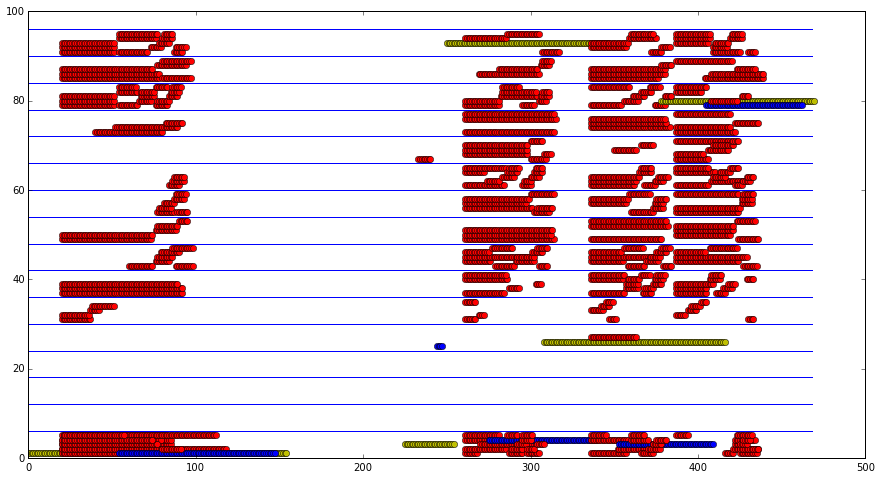

In [280]:
##### pylab.rcParams['figure.figsize'] = (15.0, 8.0)

snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
snapshot_duration = snapshot_endtime - snapshot_starttime
SnapshotDFSorted = snapshot_dataframe.sort(columns="start")
#print(DataFrameSorted)

# Initialize slot for drawing
slot = {}
for node in snapshot_dataframe.groupby('node').count().task.index:
  slot[node] = 1

slot_max = 6


for index in SnapshotDFSorted.index:
  if slot[SnapshotDFSorted.loc[index,"node"]] >= slot_max:
    slot[SnapshotDFSorted.loc[index,"node"]] = 1 #reset slot
  starttime_rescaled = SnapshotDFSorted.loc[index,"start"]/1000 - snapshot_starttime/1000
  endtime_rescaled = SnapshotDFSorted.loc[index,"end"]/1000 - snapshot_starttime/1000
  task_duration = endtime_rescaled - starttime_rescaled
  if SnapshotDFSorted.loc[index,"node"] == "null":
    current_slot = slot[SnapshotDFSorted.loc[index,"node"]]
  else:
    current_slot = (int(SnapshotDFSorted.loc[index,"node"][3:5]) * slot_max) + slot[SnapshotDFSorted.loc[index,"node"]]
    #print(str(int(SnapshotDFSorted.loc[index,"node"][3:5])))
  x = np.linspace(starttime_rescaled,endtime_rescaled-1,task_duration)
  container_data = np.linspace(current_slot,current_slot,task_duration)
  if SnapshotDFSorted.loc[index,"task"] == "MAP":
    plt.plot(x,container_data,"ro")
  elif SnapshotDFSorted.loc[index,"task"] == "REDUCE":
    plt.plot(x,container_data,"bo")
  elif SnapshotDFSorted.loc[index,"task"] == "AM":
    plt.plot(x,container_data,"yo")
  else:
    print("not applicable for %s" % index)
  slot[SnapshotDFSorted.loc[index,"node"]] = slot[SnapshotDFSorted.loc[index,"node"]] + 1

# draw line separate node:
x = np.linspace(0,snapshot_duration/1000-1,snapshot_duration/1000)
for line in np.linspace(1,len(slot)+3,len(slot)+3): # 4 locations for null
  y_value = line * slot_max
  y = np.linspace(y_value,y_value,snapshot_duration/1000)
  plt.plot(x,y,'-b')

In [ ]:
def check_profile_quality(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_task_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_task = data["container_tasks"][0]["task_type"] #First task only
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_task_list.insert(container_index,container_task)
      if not container_name:
        raise Exception('Unexpected container name')
      if container_starttime == 0:
        raise Exception('Unexpected container start time')
      if container_endtime == 0:
        raise Exception('Unexpected container end time')
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(container_name_list,container_starttime_list,container_endtime_list,container_task_list))
  DataFrame = pd.DataFrame(data = DataSet, columns=['id', 'start', 'end', 'task'])
  return DataFrame, application_starttime, application_endtime

def load_snapshot(snapshot_folders):
  snapshot_starttime = 100000000000000 # really big number
  snapshot_endtime = 0
  for applicaiton_folder in snapshot_folders: 
    _ ,application_starttime, application_endtime = load_application(applicaiton_folder)
    if application_starttime < snapshot_starttime:
      snapshot_starttime = application_starttime
    if application_endtime > snapshot_endtime:
      snapshot_endtime = application_endtime
  return snapshot_starttime, snapshot_endtime

snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))

print('Percentage CPU records during task lifetime: %f' % CPUrecords/(application_endtime-application_starttime))
print('Percentage Disk records during task lifetime: %f' % CPUrecords/(application_endtime-application_starttime))
print('Percentage Memory records during task lifetime: %f' % CPUrecords/(application_endtime-application_starttime))
print('Percentage Node_info records during task lifetime: %f' % CPUrecords/(application_endtime-application_starttime))